In [124]:
import statsmodels
import statsmodels.tsa.arima.model
import scipy

## AR(1)

In [82]:
import numpy as np
np.random.seed(12345)
arparams = np.array([.4])
maparams = np.array([])
ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag
y = statsmodels.tsa.arima_process.arma_generate_sample(ar, ma, 250)
model = statsmodels.tsa.arima.model.ARIMA(y, order=(1, 0, 0)).fit()
model.params

array([-0.04989985,  0.49616834,  0.98459052])

In [83]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  250
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -352.937
Date:                Sun, 01 Aug 2021   AIC                            711.875
Time:                        13:47:01   BIC                            722.439
Sample:                             0   HQIC                           716.127
                                - 250                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0499      0.125     -0.400      0.689      -0.294       0.195
ar.L1          0.4962      0.055      9.056      0.000       0.389       0.604
sigma2         0.9846      0.092     10.712      0.000       0.804       1.165
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.29
Prob(Q):                              0.96   Prob(JB):                         0.87
Heteroskedasticity (H):               0.91   Skew:                             0.04
Prob(H) (two-sided):                  0.67   Kurtosis:                         2.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [84]:
import numpyro
import jax

numpyro.set_host_device_count(4)

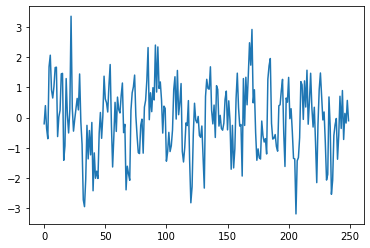

In [85]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(y)), y);

In [34]:
def ar1(y):
    alpha = numpyro.sample(
        'alpha',
        numpyro.distributions.Normal(0, 1),
    )
    mu = numpyro.sample(
        'mu',
        numpyro.distributions.Normal(0, 1),
    )
    
    sigma = numpyro.sample(
        'sigma',
        numpyro.distributions.HalfNormal(1),
    )
    
    logp = 0
    err = [y[0] - (mu)]
    for t in range(1, len(y)):
        err.append(y[t] - (alpha*y[t-1]))
    
    numpyro.factor(
        'factor',
        numpyro.distributions.Normal(0, sigma).log_prob(jax.numpy.array(err)),
    )

In [35]:
sampler = numpyro.infer.NUTS(ar1)
mcmc = numpyro.infer.MCMC(sampler, num_samples=1000, num_warmup=1000, num_chains=4)
mcmc.run(jax.random.PRNGKey(0), y=y)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [36]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.50      0.05      0.50      0.41      0.59   4295.25      1.00
        mu     -0.10      0.69     -0.10     -1.26      1.02   3269.12      1.00
     sigma      1.00      0.04      1.00      0.92      1.07   4327.81      1.00

Number of divergences: 0


In [104]:
y_pred = np.ones((4000, len(y)+steps))*np.hstack([y, np.zeros(steps)])

In [132]:
steps = 10
trace = mcmc.get_samples()
for t in range(len(y), len(y)+steps):
    pred = scipy.stats.norm(trace['alpha']*y_pred[:, t-1], trace['sigma']).rvs(len(trace['sigma']))
    y_pred[:, t] = pred

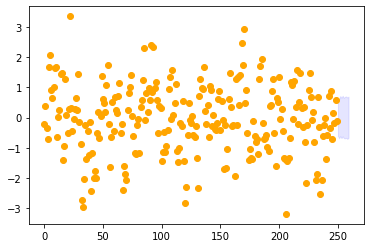

In [133]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(y)), y, 'o', color='orange');
ax.fill_between(np.arange(len(y), len(y)+steps), *numpyro.diagnostics.hpdi(y_pred[:, -steps:]), alpha=.1, color='blue');

## ARIMA(1, 0, 1)

In [134]:
import numpy as np
np.random.seed(12345)
arparams = np.array([.4])
maparams = np.array([.7])
ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag
y = statsmodels.tsa.arima_process.arma_generate_sample(ar, ma, 250)
model = statsmodels.tsa.arima.model.ARIMA(y, order=(1, 0, 1)).fit()
model.params

array([-0.0841126 ,  0.50549904,  0.68080919,  0.98412678])

In [135]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  250
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -353.491
Date:                Sun, 01 Aug 2021   AIC                            714.982
Time:                        15:31:55   BIC                            729.067
Sample:                             0   HQIC                           720.651
                                - 250                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0841      0.214     -0.394      0.694      -0.503       0.335
ar.L1          0.5055      0.059      8.498      0.000       0.389       0.622
ma.L1          0.6808      0.052     13.042      0.000       0.578       0.783
sigma2         0.9841      0.092     10.735      0.000       0.804       1.164
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.25
Prob(Q):                              0.92   Prob(JB):                         0.88
Heteroskedasticity (H):               0.91   Skew:                             0.03
Prob(H) (two-sided):                  0.68   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [136]:
def ar1(y):
    alpha = numpyro.sample(
        'alpha',
        numpyro.distributions.Normal(0, 1),
    )
    phi = numpyro.sample(
        'phi',
        numpyro.distributions.Normal(0, 1),
    )
    mu = numpyro.sample(
        'mu',
        numpyro.distributions.Normal(0, 1),
    )
    
    sigma = numpyro.sample(
        'sigma',
        numpyro.distributions.HalfNormal(1),
    )
    
    logp = 0
    err = [y[0] - (mu + phi*mu)]
    for t in range(1, len(y)):
        err.append(y[t] - (alpha*y[t-1] + phi*err[-1]))
    
    numpyro.factor(
        'factor',
        numpyro.distributions.Normal(0, sigma).log_prob(jax.numpy.array(err[1:])),
    )

In [137]:
sampler = numpyro.infer.NUTS(ar1)
mcmc = numpyro.infer.MCMC(sampler, num_samples=1000, num_warmup=1000, num_chains=4)
mcmc.run(jax.random.PRNGKey(0), y=y)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [138]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.51      0.06      0.51      0.41      0.61   3217.86      1.00
        mu     -0.07      0.57     -0.06     -0.97      0.87   3795.40      1.00
       phi      0.67      0.06      0.67      0.57      0.76   3047.94      1.00
     sigma      1.00      0.04      1.00      0.93      1.07   3587.27      1.00

Number of divergences: 0


In [104]:
y_pred = np.ones((4000, len(y)+steps))*np.hstack([y, np.zeros(steps)])

In [139]:
steps = 10
trace = mcmc.get_samples()
for t in range(len(y), len(y)+steps):
    # mu = alpha*y_1 + phi*err_1
    err_1 = y_pred[:, t-1] - (trace['alpha'])
    pred = scipy.stats.norm(trace['alpha']*y_pred[:, t-1] + trace['phi']*(y_pred[:, t-1]-y_pred[:, t-1].mean()), trace['sigma']).rvs(len(trace['sigma']))
    y_pred[:, t] = pred

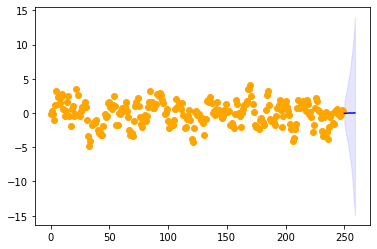

In [141]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(y)), y, 'o', color='orange');
ax.fill_between(np.arange(len(y), len(y)+steps), *numpyro.diagnostics.hpdi(y_pred[:, -steps:]), alpha=.1, color='blue');
ax.plot(np.arange(len(y), len(y)+steps), y_pred[:, -steps:].mean(axis=0), color='blue');

## seasonal arima

Don't know how to generate data, so...let's use the air passengers dataset?

In [211]:
import pandas as pd
df = pd.read_csv('AirPassengers.csv')
y = df['#Passengers'].iloc[:-10].to_numpy()

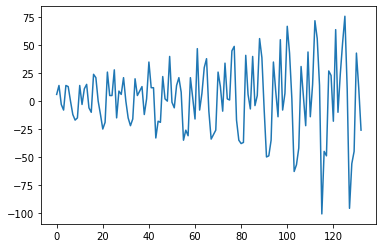

In [212]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
ax.plot(np.arange(len(y)-1), y[1:]-y[:-1]);

In [213]:
from statsmodels.tsa.stattools import pacf, acf

/home/marco/numpyro-dev/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
/home/marco/numpyro-dev/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/home/marco/numpyro-dev/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1024: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs // 2 - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
/home/marco/numpyro-dev/venv/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value enco

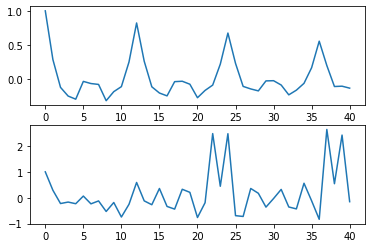

In [214]:
y_diff = y[1:] - y[:-1]
acf_data = acf(y_diff)
pacf_data = pacf(y_diff)

fig, ax = plt.subplots(nrows=2)
ax[0].plot(np.arange(len(acf_data)), acf_data)
ax[1].plot(np.arange(len(pacf_data)), pacf_data)

In [215]:
pacf_data

array([ 1.        ,  0.28747677, -0.22511158, -0.16824778, -0.23208721,
        0.06360802, -0.23699183, -0.12397987, -0.53151111, -0.18521317,
       -0.74616545, -0.25489136,  0.58943184, -0.12179267, -0.27099387,
        0.35627247, -0.33723679, -0.44029923,  0.32638584,  0.20754998,
       -0.76556305, -0.1919763 ,  2.4784282 ,  0.44278704,  2.47387352,
       -0.69354484, -0.72477112,  0.35705198,  0.17100683, -0.36313868,
       -0.03173108,  0.32117191, -0.35820416, -0.43205018,  0.55909469,
       -0.11920355, -0.83464379,  2.63836145,  0.54117831,  2.42078791,
       -0.15338543])

In [216]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [217]:
mod = SARIMAX(scale(y_diff), order=(1, 0, 1), seasonal_order=(1, 0, 0, 12))
fit = mod.fit()
fit.summary()

/home/marco/numpyro-dev/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  133
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 12)   Log Likelihood                 -57.262
Date:                             Sun, 01 Aug 2021   AIC                            122.523
Time:                                     16:28:45   BIC                            134.085
Sample:                                          0   HQIC                           127.221
                                             - 133                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5508      0.332     -1.657      0.097      -1.202       0.101
ma.L1          0.3739      0.362      1.032      0.302      -0.337       1.084
ar.S.L12       0.9606      0.021     46.031      0.000       0.920       1.001
sigma2         0.1099      0.014      8.015      0.000       0.083       0.137
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 4.12
Prob(Q):                              1.00   Prob(JB):                         0.13
Heteroskedasticity (H):               2.30   Skew:                            -0.02
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [218]:
def scale(feat):
    return (feat - np.mean(feat))/np.std(feat)

In [219]:
def sarima(y):
    alpha = numpyro.sample(
        'alpha',
        numpyro.distributions.TruncatedDistribution(numpyro.distributions.Normal(0, 1), low=-1, high=1),
    )
    phi = numpyro.sample(
        'phi',
        numpyro.distributions.TruncatedDistribution(numpyro.distributions.Normal(0, 1), low=-1, high=1),
    )
    mu = numpyro.sample(
        'mu',
        numpyro.distributions.Normal(0, 1),
    )
    alpha_12 = numpyro.sample(
        'alpha_12',
        numpyro.distributions.TruncatedDistribution(numpyro.distributions.Normal(0, 1), low=-1, high=1),
    )
    
    sigma = numpyro.sample(
        'sigma',
        numpyro.distributions.HalfNormal(1),
    )
    
    logp = 0
    err = [y[0] - (mu + phi*mu)]
    for t in range(13, len(y)):
        err.append(y[t] - (alpha*y[t-1] + alpha_12*y[t-12] - alpha*alpha_12*y[t-13] + phi*err[-1]))
    
    numpyro.factor(
        'factor',
        numpyro.distributions.Normal(0, sigma).log_prob(jax.numpy.array(err[13:])),
    )

In [220]:
sampler = numpyro.infer.NUTS(sarima)
mcmc = numpyro.infer.MCMC(sampler, num_samples=1000, num_warmup=1000, num_chains=4)
y_scaled = scale(y_diff)
mcmc.run(jax.random.PRNGKey(0), y=y_scaled)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [221]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     -0.14      0.45     -0.24     -0.76      0.67   1073.39      1.00
  alpha_12      0.99      0.01      0.99      0.97      1.00   2913.68      1.00
        mu      0.00      0.99      0.01     -1.70      1.56   2973.58      1.00
       phi     -0.08      0.44      0.00     -0.86      0.56   1090.88      1.00
     sigma      0.36      0.03      0.35      0.32      0.40   2560.58      1.00

Number of divergences: 0


In [222]:
y_pred = np.ones((4000, len(y_scaled)+steps))*np.hstack([y_scaled, np.zeros(steps)])

In [223]:
steps = 10
trace = mcmc.get_samples()
for t in range(len(y_scaled), len(y_scaled)+steps):
    err_1 = y_pred[:, t-1] - (trace['alpha'])
    pred = scipy.stats.norm(
        (
            trace['alpha']*y_pred[:, t-1]
            + trace['alpha_12']*y_pred[:, t-12]
            - trace['alpha_12']*trace['alpha']*y_pred[:, t-13]
            + trace['phi']*(y_pred[:, t-1]-y_pred[:, t-1].mean())
        ),
        trace['sigma']).rvs(len(trace['sigma']),
    )
    y_pred[:, t] = pred

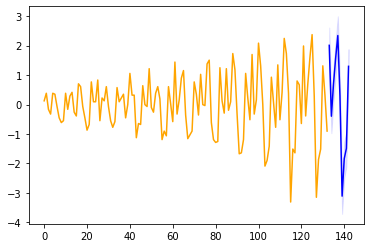

In [224]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(y_scaled)), y_scaled, color='orange');
ax.fill_between(np.arange(len(y_scaled), len(y_scaled)+steps), *numpyro.diagnostics.hpdi(y_pred[:, -steps:]), alpha=.1, color='blue');
ax.plot(np.arange(len(y_scaled), len(y_scaled)+steps), y_pred[:, -steps:].mean(axis=0), color='blue');

In [225]:
y_pred_unscaled = y_pred*np.std(y_diff)+np.mean(y_diff)

In [226]:
y_pred_unscaled

array([[  6.        ,  14.        ,  -3.        , ..., -49.40086522,
        -30.30332354,  19.58451706],
       [  6.        ,  14.        ,  -3.        , ..., -42.19148198,
        -53.87044255,  36.23749975],
       [  6.        ,  14.        ,  -3.        , ..., -67.38758703,
        -45.61535966,  43.59555177],
       ...,
       [  6.        ,  14.        ,  -3.        , ..., -46.63430447,
        -47.85335207,  36.61790497],
       [  6.        ,  14.        ,  -3.        , ..., -60.73951987,
        -14.87519875,  38.94112275],
       [  6.        ,  14.        ,  -3.        , ..., -52.14730109,
        -42.61984303,  24.88650745]])

In [227]:
y_pred.shape

(4000, 143)

In [228]:
restored = [np.ones(4000)*y[0]]
for i in range(y_pred_unscaled.shape[1]):
    restored.append(restored[-1]+y_pred_unscaled[:, i])
restored = np.array(restored).T
restored.shape

(4000, 144)

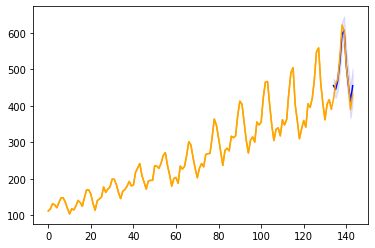

In [231]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(y)), y, color='orange');
ax.fill_between(np.arange(len(y), len(y)+steps), *numpyro.diagnostics.hpdi(restored[:, -steps:]), alpha=.1, color='blue');
ax.plot(np.arange(len(y), len(y)+steps), restored[:, -steps:].mean(axis=0), color='blue');
ax.plot(np.arange(len(df)), df['#Passengers'], color='orange');